In [1]:
import sys, os
import pandas as pd
import numpy as np 

# plotting functions

from bokeh.io import output_file, show
from bokeh.plotting import figure 
from bokeh.models import Legend
from bokeh.layouts import column
from bokeh.palettes import Category20 as palettes, PaletteCollection
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings('ignore')

# Tools

用来计时用的装饰器，可以来看哪些函数比较耗时

In [2]:
from functools import wraps
from time import time

# You could use a logger instead
def timeit():
    def wrap(func):
        @wraps(func)
        def wrapped(*args, **kwargs):
            t0 = time()
            print(f"{func.__name__} started")
            ret = func(*args, **kwargs)
            ts = round(time()-t0, 3)

            print(f"{func.__name__} took {ts} seconds")
            
            return ret
        
        return wrapped
    
    return wrap

# Read Data

In [3]:
from xlsx2csv import Xlsx2csv
from io import StringIO
import pandas as pd

@timeit()
def read_excel(path: str, sheet_name: str) -> pd.DataFrame:
    buffer = StringIO()
    Xlsx2csv(path, outputencoding="utf-8", sheet_name=sheet_name).convert(buffer)
    buffer.seek(0)
    df = pd.read_csv(buffer)
    return df

ST = read_excel(r'ST.xlsx', sheet_name='是否ST').set_index('Unnamed: 0').dropna(how='all', axis=1)
print(f'ST data loaded! with shape: {ST.shape}')
status = read_excel(r'status.xlsx', sheet_name='日交易状态').set_index('Unnamed: 0').dropna(how='all', axis=1)
print(f'status data loaded! with shape {status.shape}')
class_ind = read_excel(r'SW_ind_1.xlsx', sheet_name='所示申万一级行业指数代码').set_index('Unnamed: 0').dropna(how='all', axis=1)
print(f'industry data loaded! with shape {class_ind.shape}')
trade_days = read_excel(r'trade_days.xlsx', sheet_name='日已上市天数').set_index('Unnamed: 0').dropna(how='all', axis=1)
print(f'trade_days data loaded! with shape {trade_days.shape}')
close = read_excel(r'weighted_close.xlsx', sheet_name='日后复权收盘价').set_index('Unnamed: 0').dropna(how='all', axis=1)
print(f'close data loaded! with shape {close.shape}')
mktcap = read_excel(r'marketcap.xlsx', sheet_name='日流通股本').set_index('Unnamed: 0').dropna(how='all', axis=1)

ST = ST.drop('日期', axis=1)
status = status.drop('日期', axis=1)
class_ind = class_ind.drop('日期', axis=1)
trade_days = trade_days.drop('日期', axis=1)
close = close.drop('日期', axis=1)
mktcap = mktcap.drop('日期', axis=1)

read_excel started
read_excel took 86.106 seconds
ST data loaded! with shape: (4112, 4111)
read_excel started
read_excel took 60.314 seconds
status data loaded! with shape (4112, 4111)
read_excel started
read_excel took 28.028 seconds
industry data loaded! with shape (4112, 1648)
read_excel started
read_excel took 68.016 seconds
trade_days data loaded! with shape (4112, 4111)
read_excel started
read_excel took 116.163 seconds
close data loaded! with shape (4112, 4111)
read_excel started
read_excel took 91.165 seconds


In [12]:
date_lst = class_ind.columns
start_date = date_lst[0]
end_date = date_lst[-1]
print(f'The start date is {start_date}, The end date is {end_date}')

The start date is 20140303, The end date is 20201130


# Factor Construction

Here, we construct a simple momentum factor by calculating the return in 3 days of each stocks. For missing values, the sample uses the mean of cross-section to fill na values. You could use 0 or forward fill etc. instead.

In [4]:
f = close.pct_change(3, axis=1).dropna(how='all', axis=1)
f = f.replace([-np.inf, np.inf], np.nan).dropna(how='all', axis=1)
f = f.fillna(f.mean())
f

,20040106,20040107,20040108,20040109,20040112,20040113,20040114,20040115,20040116,20040129,...,20201117,20201118,20201119,20201120,20201123,20201124,20201125,20201126,20201127,20201130
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
000001.SZ,0.096357,0.086806,0.054933,-0.032154,-0.021299,-0.024442,0.000000,-0.009793,0.010893,0.055371,...,0.009626,0.074505,0.085204,0.057768,0.062839,0.027056,0.010604,-0.006116,0.017562,0.035677
000002.SZ,0.128440,0.091703,0.027360,-0.023035,0.002667,-0.017310,0.042996,0.037234,0.075881,0.089096,...,0.006384,0.058864,0.058562,0.030718,0.009103,-0.001941,-0.002268,-0.003222,0.024635,-0.003247
000004.SZ,-0.076372,-0.035980,0.021656,0.028424,0.029601,0.023691,0.033920,0.000000,-0.003654,0.053463,...,-0.078130,-0.031679,0.065665,0.115603,0.052614,-0.075107,-0.053719,-0.080423,-0.060325,-0.072220
000005.SZ,-0.007491,-0.022556,0.034884,0.022642,0.042308,0.044944,0.011070,-0.007380,-0.028674,0.029197,...,0.019084,-0.003731,-0.007435,0.000000,0.011236,0.003745,-0.007491,-0.037037,-0.037313,-0.026415
000006.SZ,-0.036190,-0.026515,0.013462,0.021739,0.003891,0.003795,0.021277,0.025194,0.028355,0.066288,...,0.008711,0.024691,0.008741,-0.003454,-0.006885,-0.005199,-0.015598,-0.024263,-0.008711,0.008803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688600.SH,0.012032,0.014490,0.028033,0.023203,0.025404,0.018240,0.022856,0.007885,0.005385,0.038382,...,-0.017604,0.005888,0.009264,0.030363,0.015122,0.007729,-0.011594,-0.014897,-0.019175,0.001955
688777.SH,0.012032,0.014490,0.028033,0.023203,0.025404,0.018240,0.022856,0.007885,0.005385,0.038382,...,0.004106,0.007965,0.000608,0.012450,0.011780,0.008558,-0.009887,-0.017360,0.132284,0.027341
688788.SH,0.012032,0.014490,0.028033,0.023203,0.025404,0.018240,0.022856,0.007885,0.005385,0.038382,...,0.055255,0.038806,0.056805,0.055276,0.039272,0.048899,0.055714,0.026728,-0.005649,0.032206


剔除每一期的新股、ST股、停牌股等异常样本。ST是指境内上市公司被进行特别处理的股票，被标记为ST股的公司往往有财务风险，一般不纳入回测范围。新股由于A股特色（有种专门的策略叫做打新股）往往会出现连续几板涨停，为了不影响对因子有效性的判断，一般不纳入回测范围，这里取新股为上市时间小于1年的股票

In [5]:
f[np.logical_or(ST[f.columns].to_numpy() == 1, trade_days[f.columns].to_numpy() <= 365, status[f.columns].to_numpy() != '交易')] = np.nan
f = f.dropna(how='all', axis=0)
f

,20040106,20040107,20040108,20040109,20040112,20040113,20040114,20040115,20040116,20040129,...,20201117,20201118,20201119,20201120,20201123,20201124,20201125,20201126,20201127,20201130
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
000001.SZ,0.096357,0.086806,0.054933,-0.032154,-0.021299,-0.024442,0.000000,-0.009793,0.010893,0.055371,...,0.009626,0.074505,0.085204,0.057768,0.062839,0.027056,0.010604,-0.006116,0.017562,0.035677
000002.SZ,0.128440,0.091703,0.027360,-0.023035,0.002667,-0.017310,0.042996,0.037234,0.075881,0.089096,...,0.006384,0.058864,0.058562,0.030718,0.009103,-0.001941,-0.002268,-0.003222,0.024635,-0.003247
000004.SZ,-0.076372,-0.035980,0.021656,0.028424,0.029601,0.023691,0.033920,0.000000,-0.003654,0.053463,...,-0.078130,-0.031679,0.065665,0.115603,0.052614,-0.075107,-0.053719,-0.080423,-0.060325,-0.072220
000005.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.019084,-0.003731,-0.007435,0.000000,0.011236,0.003745,-0.007491,-0.037037,-0.037313,-0.026415
000006.SZ,-0.036190,-0.026515,0.013462,0.021739,0.003891,0.003795,0.021277,0.025194,0.028355,0.066288,...,0.008711,0.024691,0.008741,-0.003454,-0.006885,-0.005199,-0.015598,-0.024263,-0.008711,0.008803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603993.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.061611,0.050575,-0.010823,0.055804,0.050328,0.063457,-0.021142,-0.045833,-0.059671,-0.008639
603996.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
603997.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.077998,0.070340,-0.012155,0.009719,0.035049,0.048098,-0.028877,-0.056085,-0.058698,-0.049559


# Statistical Overview

## Distribution

Here we use winsorization to deal with outliers

In [6]:
from scipy.stats.mstats import winsorize

def plot_distribution(data, winsor=False):
    data_2 = data.copy()
    trade_date = data_2.columns
    trade_date = pd.to_datetime(trade_date)
    trade_year = [x.year for x in trade_date]
    data_2.columns = trade_year
    years = list(set(trade_year))
    years = np.sort(years)
    f_year = pd.DataFrame(index=data_2.index)
    r = len(years) // 3 + 1
    c = 3
    fig, axes = plt.subplots(r,c,figsize=(r*4,c*6))
    for i,year in enumerate(years):
        arr = data_2[year].to_numpy().reshape((-1,1))
        arr = np.ravel(arr)
        arr = arr[~np.isnan(arr)]
        if winsor:
            arr = np.array(winsorize(arr))
        df = pd.DataFrame()
        df[year] = arr
        sns.kdeplot(arr, shade=True, ax=axes[int(i/c), i%c], label=year)
        axes[int(i/c), i%c].legend()
    
    plt.suptitle('Yearly distribution of factors')


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


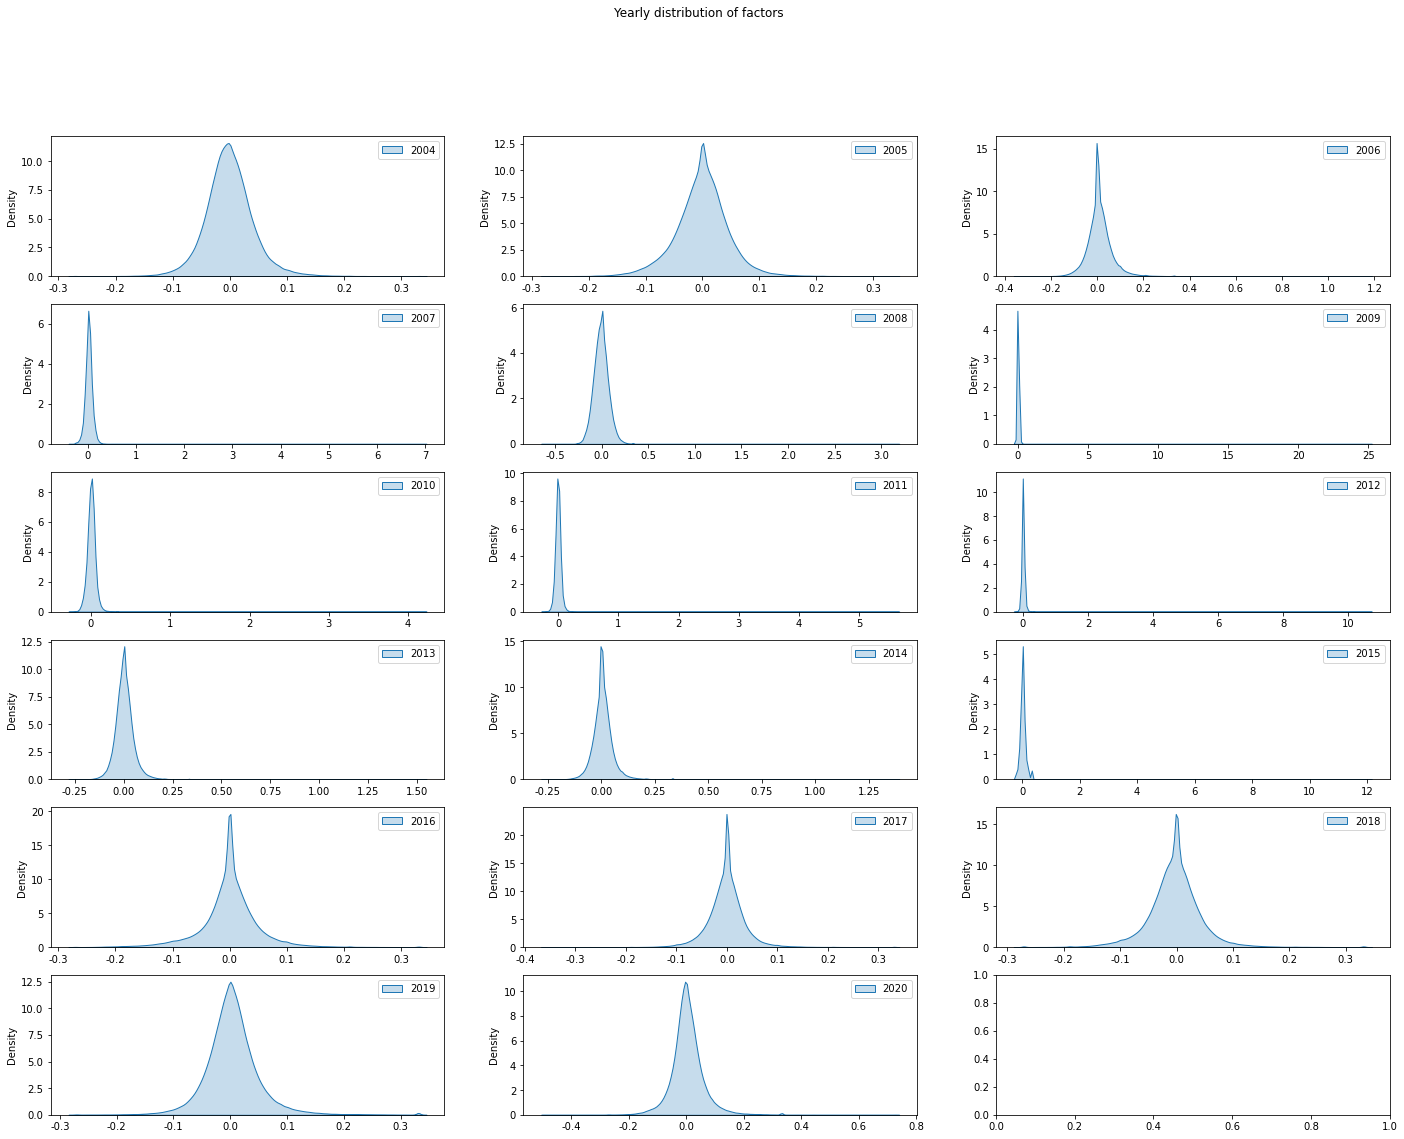

In [7]:
# unwinsorized factor
plot_distribution(f)

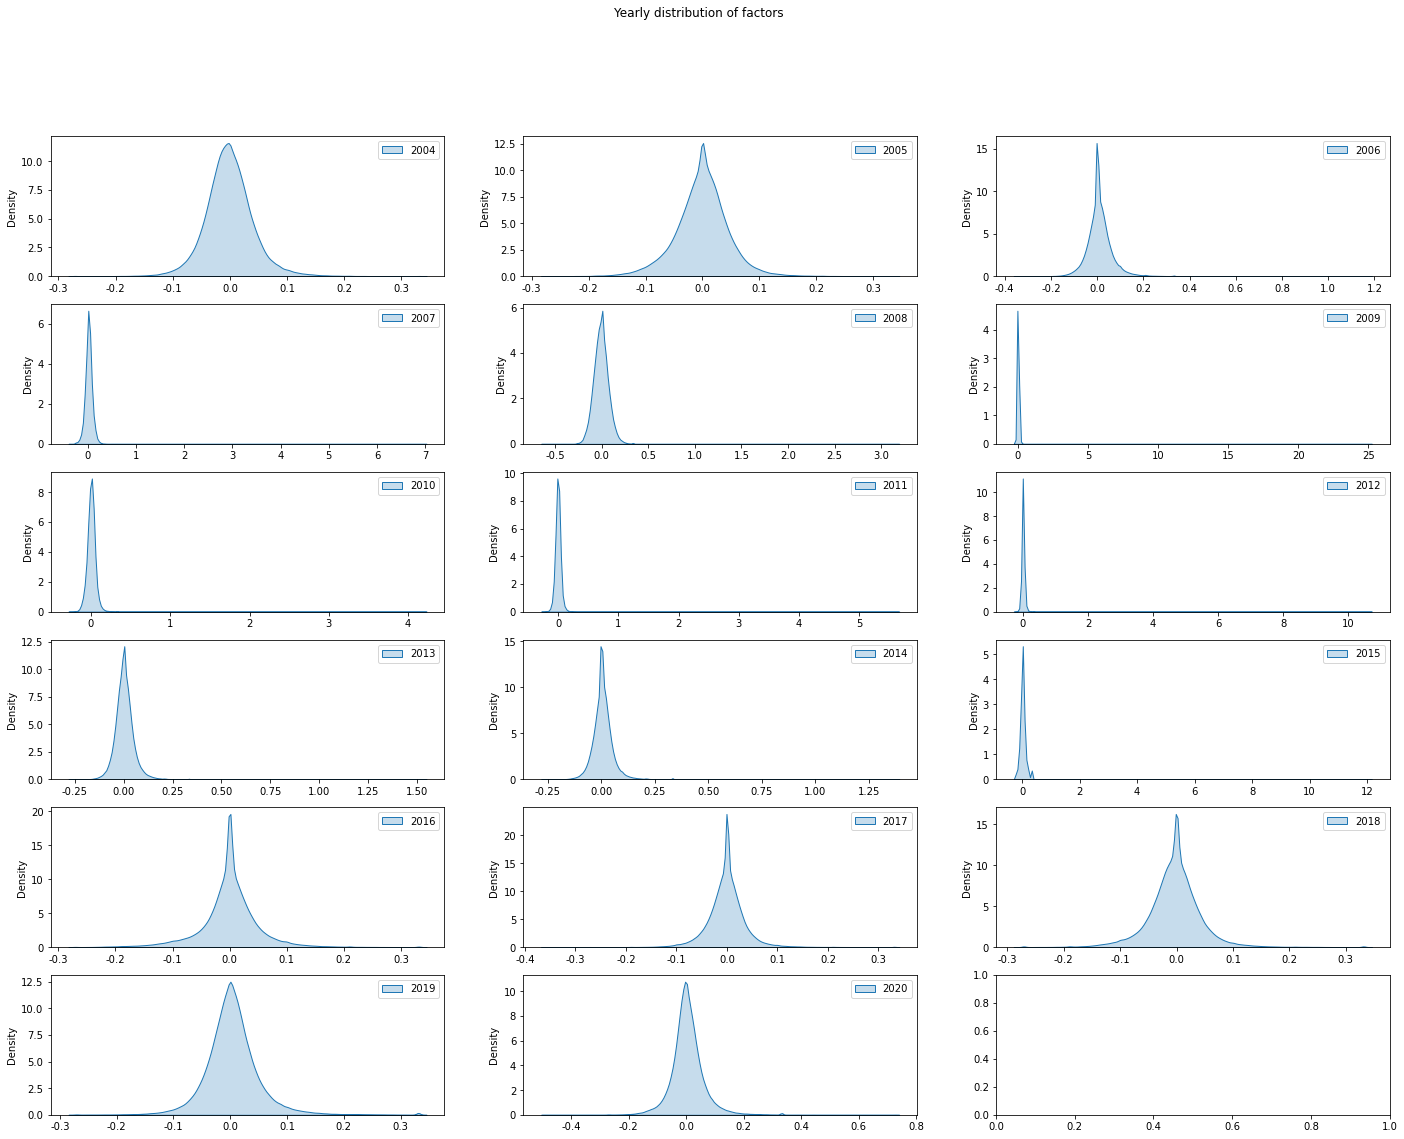

In [8]:
plot_distribution(f, winsor=True)

## Auto-correlation

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


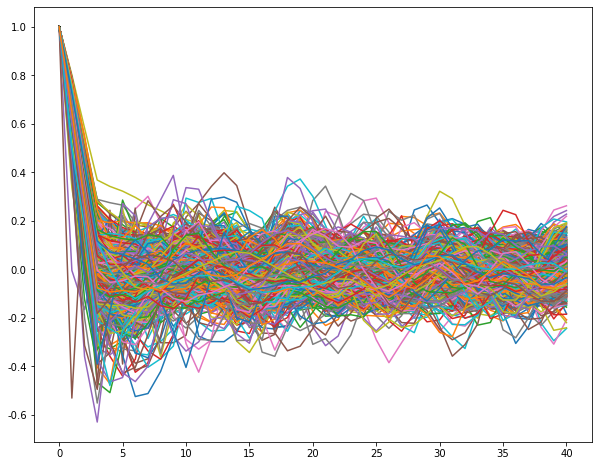

In [9]:
from statsmodels.tsa.stattools import acf
from pandarallel import pandarallel

pandarallel.initialize()

def factor_acf(data):
    data_2 = data.copy()
    data_2 = data_2.dropna()
    return acf(data_2)

acf_df = f.parallel_apply(factor_acf, axis=1)
acf_df = pd.DataFrame(pd.DataFrame(acf_df)[0].tolist(), index=acf_df.index)

def plot_acf(data):
    df = data.copy()
    fig, ax = plt.subplots(figsize=(10,8))
    for idx, r in df.iterrows():
        ax.plot(df.columns, r)

plot_acf(acf_df)

In [ ]:
# # For Windows Users

# from statsmodels.tsa.stattools import acf
# # from pandarallel import pandarallel

# # pandarallel.initialize()

# def factor_acf(data):
#     data_2 = data.copy()
#     data_2 = data_2.dropna()
#     return acf(data_2)

# acf_df = f.apply(factor_acf, axis=1)
# acf_df = pd.DataFrame(pd.DataFrame(acf_df)[0].tolist(), index=acf_df.index)

# def plot_acf(data):
#     df = data.copy()
#     fig, ax = plt.subplots(figsize=(10,8))
#     for idx, r in df.iterrows():
#         ax.plot(df.columns, r)

# plot_acf(acf_df)

## Industry analysis

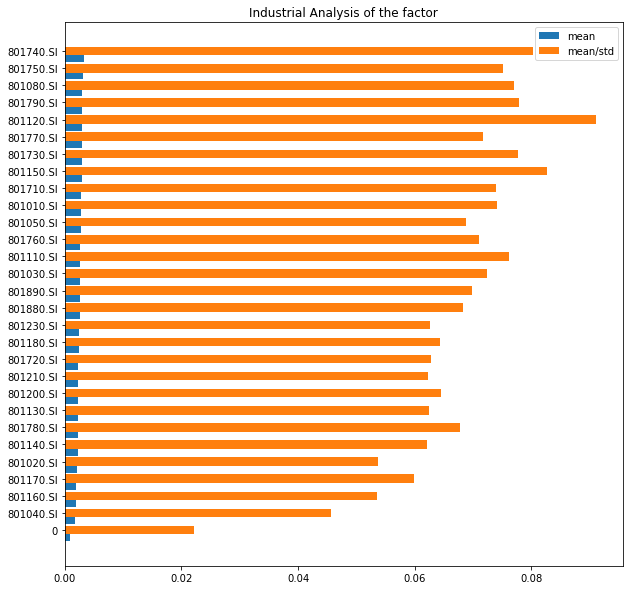

In [10]:
def plot_industry(class_ind, factor):
    c_ind = class_ind.iloc[:,-1]
    c_f = factor.groupby(c_ind).mean()
    c_mean = c_f.mean(axis=1)
    c_std = c_f.std(axis=1)
    c_norm = c_mean / c_std
    c_mean = c_mean.sort_values()
    c_norm = c_norm.loc[c_mean.index]
    c_idx = c_mean.index
    plt.figure(figsize=(10,10))
    plt.barh(y=np.arange(c_mean.shape[0]), height=0.5, tick_label = c_idx, width=c_mean, label='mean')
    plt.barh(y=np.arange(c_norm.shape[0])+0.4, height=0.5, tick_label = c_idx, width=c_norm, label='mean/std')
    plt.title('Industrial Analysis of the factor')
    plt.legend()

plot_industry(class_ind, f)

# Normalization

为了剔除因子在行业、市值上的特异性，过程一般为将因子值相对于行业的dummy variable与市值做回归，取残差为中性化后的因子值。

norm started
norm took 13.739 seconds


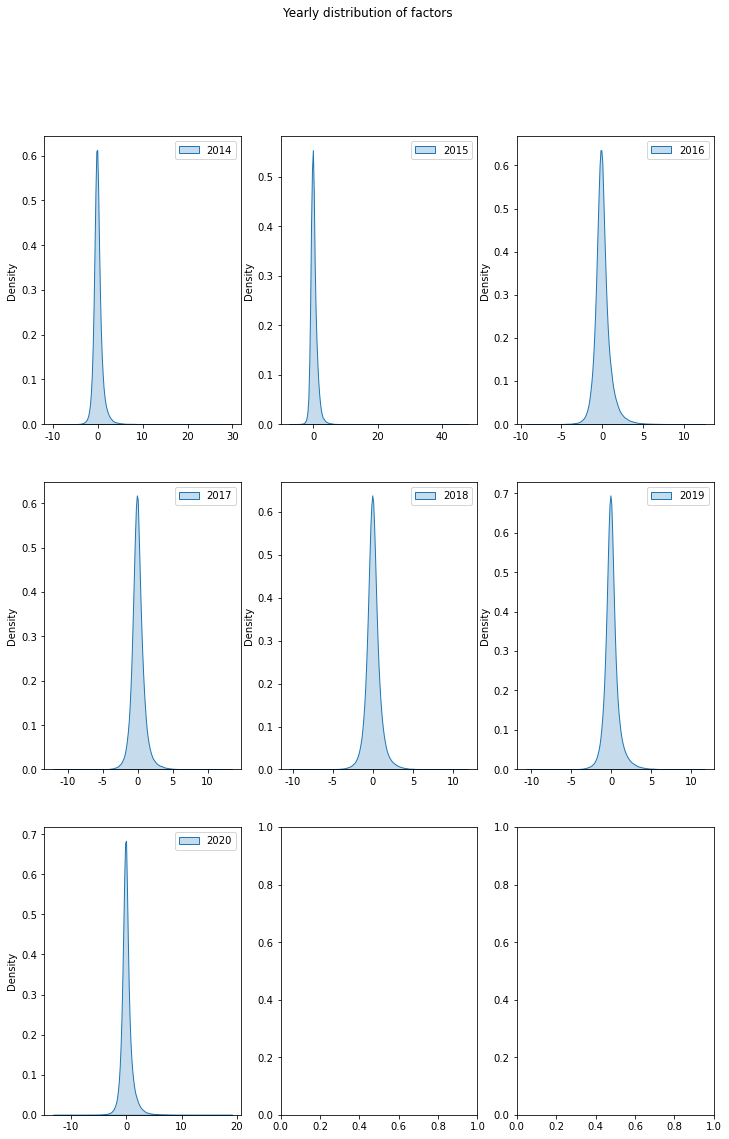

In [13]:
import statsmodels.api as sm
from joblib import Parallel, delayed
import multiprocessing

def Ols_resid(data):
    y = data.factor
    ind = pd.get_dummies(data['industry'], prefix='class', prefix_sep='-', dummy_na=False, drop_first=True)
    cap = data['cap']
    x = pd.concat([ind, cap], axis=1)
    df = pd.concat([y,x], axis=1)
    if df.dropna().shape[0] > 0:
        resid = sm.OLS(y, x, missing='drop').fit().resid
        resid = (resid - resid.mean()) / resid.std()
        return resid.reindex(df.index)
    else:
        print('nan values exist in every row of pd.concat([y,x], axis=1)')
        return y


@timeit()
def norm(data, class_ind, mktcap, winsor=False):
    data_2 = data[date_lst]
    class_ind_2 = class_ind[date_lst]
    mktcap_2 = mktcap[date_lst]

    def apply_parrallel(groups, func):
        retList = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(g) for name,g in groups)
        return pd.concat(retList)
        
    if winsor:
        data_2 = data_2.parallel_apply(lambda x: winsorize(x), axis=1)
    
    df = pd.DataFrame(data_2.T.stack(), columns=['factor'])
    df['industry'] = class_ind_2.T.stack()
    df['cap'] = mktcap_2.T.stack()
    
    new_factor = apply_parrallel(df.groupby(level=0, axis=0), Ols_resid).unstack().T
    
    return new_factor

new_f = norm(f, class_ind, mktcap)  
plot_distribution(new_f)

# IC analysis

IC的定义：因子值和股票未来一期收益率的相关系数

getIC started
getIC took 4.864 seconds
IC胜率为: 0.586269744835966


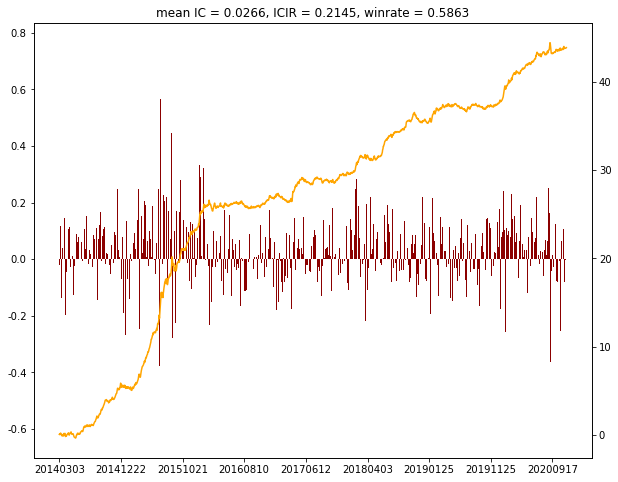

In [14]:
from functools import partial

def get_corr(df, method='pearson'):
    '''
    method: spearman or pearson
    '''
    df_2 = df.dropna()
    return df['factor'].corr(df['return'], method=method)

@timeit()
def getIC(factor, ret, method='pearson'):

    def apply_parrallel(groups, func):
        retList = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(g) for name,g in groups)
        return retList

    joint_cols = list(set(ret.columns) & set(factor.columns))
    joint_cols.sort()
    ret = ret[joint_cols]
    factor = factor[joint_cols]
    factor_2 = pd.DataFrame(factor.T.stack(), columns=['factor'])
    factor_2['return'] = ret.T.stack()
    p_get_corr = partial(get_corr, method=method)
    IC = apply_parrallel(factor_2.groupby(level=0, axis=0), get_corr)
    result = pd.DataFrame()
    result['IC'] = IC
    result.index = joint_cols
    return result

def plot_IC(IC):
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes()
    xtick = np.arange(0, IC.shape[0],200)
    xticklabel = pd.Series(IC.index[xtick])
    plt.bar(np.arange(IC.shape[0]), IC['IC'], color='darkred')
    ax1 = plt.twinx()
    ax1.plot(np.arange(IC.shape[0]), IC.cumsum(), color='orange')
    ax.set_xticks(xtick)
    ax.set_xticklabels(xticklabel)
    winrate = (np.sum(IC > 0) / len(IC)).values[0]
    plt.title(f'mean IC = {round(IC["IC"].mean(),4)}, ICIR = {round(IC["IC"].mean()/IC["IC"].std(), 4)}, winrate = {round(winrate,4)}')

ret = close.pct_change(1, axis=1).dropna(how='all', axis=1).dropna(how='all', axis=0)
ret.columns = close.columns[:-1]
IC = getIC(new_f, ret)
winrate = (np.sum(IC > 0) / len(IC)).values[0]
plot_IC(IC)
print(f'IC胜率为: {winrate}')

## IC decay

如果IC衰减的很慢，则说明因子的稳定性较好，可以用在中长线的策略内，如果IC衰减的很快，则说明因子适合短线

get_HalfDecay started
getIC started
getIC took 4.848 seconds
getIC started
getIC took 4.546 seconds
getIC started
getIC took 4.443 seconds
getIC started
getIC took 4.457 seconds
getIC started
getIC took 4.38 seconds
getIC started
getIC took 4.55 seconds
getIC started
getIC took 4.338 seconds
getIC started
getIC took 4.658 seconds
getIC started
getIC took 4.204 seconds
getIC started
getIC took 4.631 seconds
getIC started
getIC took 4.311 seconds


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


get_HalfDecay took 50.626 seconds


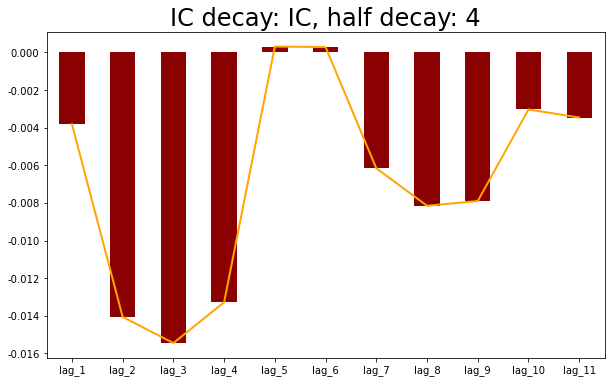

In [15]:
def calc_HalfDecay(x):
    target = abs(x[0]/2)
    pos = np.where(x.abs() < target)
    if len(pos[0]) > 0:
        return pos[0][0]
    else:
        return f'>{len(x)}'

@timeit()
def get_HalfDecay(factor, close, lag=12, method='pearson'):
    halfic = []
    ret = close.pct_change(1, axis=1).dropna(how='all', axis=1).dropna(how='all', axis=0)
    ret.columns = close.columns[:-1]
    for i in range(1, lag):
        ret1 = ret.T.shift(-i).dropna(how='all', axis=0).T
        ret1 = ret1.rename(columns = {ret1.columns[-1]: 'ret'})
        ic = getIC(factor, ret1, method)
        halfic.append(pd.DataFrame(ic.mean(), columns=[f'lag_{i}']))
    halfic = pd.concat(halfic, axis=1)
    halficvalue = halfic.parallel_apply(calc_HalfDecay, axis=1)

    return (halfic, halficvalue)

def plot_HalfDecay(halfic, haficvalue):
    for i in range(halfic.shape[0]):
        fig = plt.figure(figsize=(10,6))
        halfic.iloc[i].plot(kind='bar', color='darkred')
        halfic.iloc[i].plot(kind='line', color='orange', linewidth=2)
        plt.title(f'IC decay: {halfic.index[i]}, half decay: {str(halficvalue[i]).strip(">")}', fontsize=24)


halfic, halficvalue = get_HalfDecay(new_f, close)
plot_HalfDecay(halfic, halficvalue)

In [16]:
halfic

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
IC,-0.003811,-0.014062,-0.015452,-0.01328,0.000315,0.000286,-0.006156,-0.008151,-0.007897,-0.003029,-0.003461


## 分层IC

按行业、市值、因子值大小等分组测算IC值

### 按因子大小测算IC

get_groupIC started
get_groupIC took 8.167 seconds
(5, 1646)


,20140303,20140304,20140305,20140306,20140307,20140310,20140311,20140312,20140313,20140314,...,20201116,20201117,20201118,20201119,20201120,20201123,20201124,20201125,20201126,20201127
0,0.165361,0.029382,-0.042438,0.062889,-0.178897,-0.268859,-0.170747,0.029891,0.040921,0.040229,...,0.088287,-0.212644,-0.038653,0.064709,-0.103598,-0.090778,-0.120439,-0.060386,-0.025327,NaN
1,-0.013407,-0.007448,0.012281,-0.106820,-0.000211,-0.025146,-0.033485,-0.022968,0.132803,-0.096982,...,-0.037070,0.042083,0.016610,-0.063179,0.066606,-0.092601,-0.075272,-0.099083,-0.063273,NaN
2,0.016208,-0.031029,0.026465,0.058362,-0.087444,0.105571,-0.049965,0.054958,-0.046024,-0.007756,...,-0.022303,-0.039439,0.072109,-0.042829,0.080081,0.028426,0.039474,0.059629,-0.034777,NaN
3,-0.053573,-0.062323,0.020130,0.024465,0.004581,0.045111,-0.078757,0.021330,-0.026349,-0.060658,...,-0.056628,-0.074242,-0.023117,-0.038659,-0.028274,0.010428,0.019959,0.063064,-0.000395,NaN
4,-0.166723,0.000979,-0.073665,0.008963,0.142151,0.019149,0.001728,-0.077717,-0.114281,-0.082504,...,0.058603,-0.014810,-0.068019,0.035989,0.098743,0.051472,0.050091,0.078883,0.142487,NaN


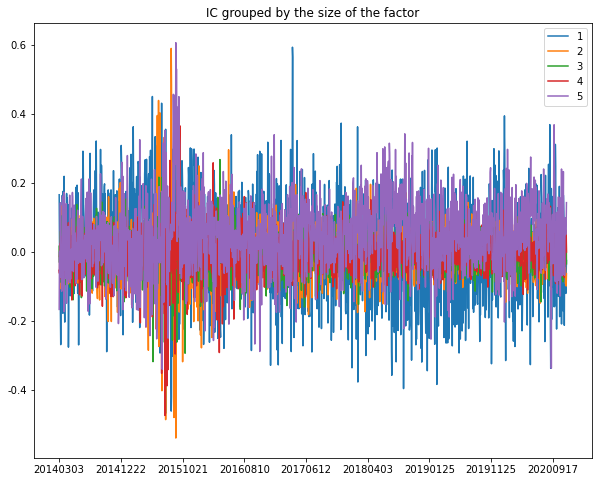

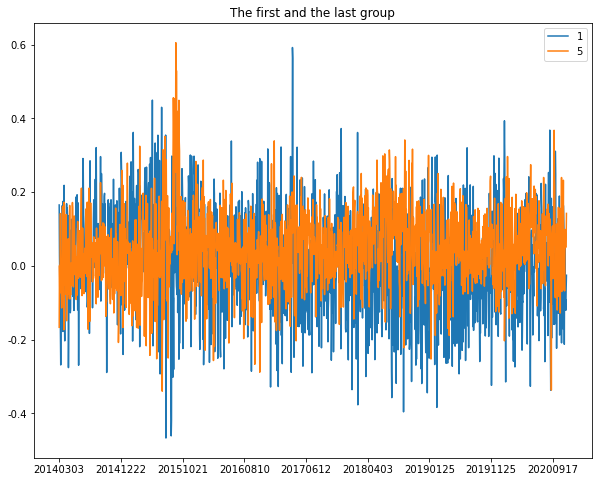

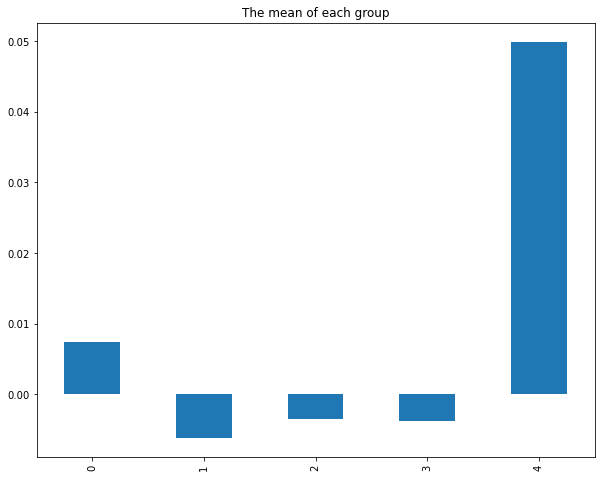

In [17]:
def calc_groupIC(df, groups=10, method='pearson'):
    # labels = [x+1 for x in range(groups)]
    df['q'] = groups - pd.qcut(df['factor'], groups, labels=False)
    p_corr = partial(get_corr, method=method)
    
    def apply_parrallel(groups, func):
        retList = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(g) for name,g in groups)
        return retList

    mean_ic = apply_parrallel(df.groupby('q'), get_corr)

    return mean_ic

@timeit()
def get_groupIC(factor, ret, groups=5, method='pearson'):
    joint_cols = list(set(factor.columns) & set(ret.columns))
    joint_cols.sort()
    factor_2 = factor[joint_cols]
    ret_2 = ret[joint_cols]
    ret_2 = ret_2.T.shift(-1).T
    df = pd.DataFrame(factor_2.T.stack(), columns=['factor'])
    df['return'] = ret_2.T.stack()
    
    def apply_parrallel(groups, func):
        retList = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(g) for name,g in groups)
        return retList
    
    p_calc = partial(calc_groupIC, groups=groups, method=method)
    IC = apply_parrallel(df.groupby(level=0, axis=0), p_calc)
    IC = pd.DataFrame(IC).T
    IC.columns = joint_cols

    return IC

def plot_groupIC(grouped_IC):
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes()
    xtick = np.arange(0, IC.shape[0], 200)
    xticklabel = pd.Series(grouped_IC.columns[xtick])
    for idx in grouped_IC.index:
        data = grouped_IC.loc[idx]
        plt.plot(data.index, data.values, label=f'{idx+1}')
    ax.set_xticks(xtick)
    ax.set_xticklabels(xticklabel)
    ax.legend()
    plt.title('IC grouped by the size of the factor')

    fig = plt.figure(figsize=(10,8))
    ax = plt.axes()
    xtick = np.arange(0, IC.shape[0], 200)
    xticklabel = pd.Series(grouped_IC.columns[xtick])
    selected = [grouped_IC.index[0], grouped_IC.index[-1]]
    for idx in selected:
        data = grouped_IC.loc[idx]
        plt.plot(data.index, data.values, label=f'{idx+1}')
    ax.set_xticks(xtick)
    ax.set_xticklabels(xticklabel)
    ax.legend()
    plt.title('The first and the last group')

    fig = plt.figure(figsize=(10,8))
    grouped_IC.mean(axis=1).plot(kind='bar')
    plt.title('The mean of each group')


grouped_IC = get_groupIC(new_f, ret)
print(grouped_IC.shape)
plot_groupIC(grouped_IC)
grouped_IC


Comment: 因子值最大的组IC值最大，这是一个比较好的现象，因为这是一个动量因子，说明在构建多空组合时我们的收益大部分会来自于多头组合，而A股做空成本较高，一般股票策略会构建只有多头的组合。

### 按行业测算IC

get_IndustryIC started


/opt/homebrew/Caskroom/miniforge/base/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/homebrew/Caskroom/miniforge/base/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniforge/base/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/homebrew/Caskroom/miniforge/base/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniforge/base/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/homebrew/Ca

get_IndustryIC took 16.855 seconds


,0,1,2,3,4,5,6,7,8,9,...,1636,1637,1638,1639,1640,1641,1642,1643,1644,1645
801780.SI,1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,1.000000,...,-0.096146,-0.288676,-0.050008,-0.448333,-0.418535,-0.043882,0.156438,-0.118445,-0.221905,-0.209287
801180.SI,0.063548,0.085408,0.042765,0.089494,0.249567,0.046018,0.187723,0.048333,0.057538,-0.048022,...,0.105947,-0.055729,0.203430,0.102290,-0.065863,-0.063686,0.037441,0.011550,-0.084219,0.199858
801150.SI,0.023265,0.372268,0.000191,-0.119116,-0.103514,0.005851,-0.051610,0.170350,0.199061,-0.261868,...,-0.133172,0.078987,0.242336,0.179609,0.113903,0.074870,0.011195,0.423406,-0.062942,0.051969
801210.SI,-0.028051,0.001855,0.038705,-0.107595,0.079818,-0.003199,0.014954,-0.125691,0.090099,0.100888,...,-0.134896,-0.055555,-0.002445,0.082681,0.048228,0.012490,-0.051064,-0.123165,0.109812,-0.103044
801230.SI,-0.640202,0.144050,0.159400,0.100708,-0.417312,0.128440,-0.210392,-0.395289,-0.079912,-0.071812,...,0.142058,0.070899,0.129549,-0.210019,-0.341160,0.093760,-0.081567,0.263111,-0.050542,0.529135
801710.SI,-0.053752,0.179382,0.089658,-0.116935,0.033890,0.057767,-0.047279,-0.024148,-0.075859,-0.021412,...,-0.058767,-0.142542,0.261110,0.145924,0.025708,-0.008767,0.137240,0.161778,0.179295,-0.064293
801110.SI,0.002019,0.067625,-0.009757,0.011603,0.110088,-0.021137,0.021410,0.128198,-0.016229,-0.100672,...,-0.024773,-0.076778,-0.047472,-0.110385,NaN,-0.017682,-0.151487,-0.143763,-0.058615,0.042004
801880.SI,0.029099,-0.150233,-0.042772,-0.009950,-0.149450,0.104353,-0.096431,-0.175138,-0.110233,-0.027919,...,-0.174509,-0.058724,-0.004491,0.042473,-0.093160,0.210915,0.090544,0.060983,0.088384,-0.167153
801120.SI,-0.197178,0.000644,-0.089056,0.089774,-0.141782,0.090845,0.004086,-0.070546,-0.024271,0.016529,...,0.055903,-0.017183,-0.004552,-0.030133,0.060109,0.080186,0.320284,0.057685,-0.101377,0.168942
801080.SI,-0.074497,-0.075851,0.065887,0.156386,-0.065567,-0.073672,-0.140194,0.004851,0.094432,0.035941,...,-0.015978,-0.027826,0.117230,0.082916,0.023584,-0.132676,-0.327392,-0.080698,0.077651,0.242209


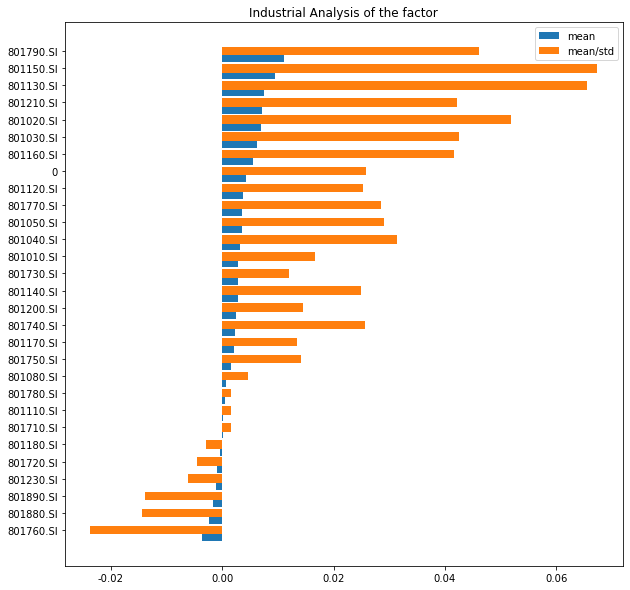

In [18]:
def calc_industryIC(df, method='pearson'):

    def apply_parrallel(groups, func):
        retList = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(g) for name,g in groups)
        return retList
    
    p_get_corr = partial(get_corr, method=method)
    result = apply_parrallel(df.groupby('industry'), p_get_corr)
    return result

@timeit()
def get_IndustryIC(factor, ret, industry):
    joint_cols = list(set(factor.columns) & set(industry.columns) & set(ret.columns))
    factor_2 = factor[joint_cols]
    industry_2 = industry[joint_cols]
    ret_2 = ret[joint_cols].T.shift(-1).T
    df = pd.DataFrame(factor_2.T.stack(), columns=['factor'])
    df['industry'] = industry_2.T.stack()
    df['return'] = ret_2.T.stack()

    def apply_parrallel(groups, func):
        retList = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(g) for name,g in groups)
        return retList

    result = apply_parrallel(df.groupby(level=0, axis=0), calc_industryIC)
    result = pd.DataFrame(result).T
    result.index = industry_2.iloc[:,-1].unique()[:-1] #为什么不取最后一个element的原因见下一个cell

    return result    

def plot_IndustryIC(ind_IC):
    mean_IC = ind_IC.T.mean()
    std_IC = ind_IC.T.std()
    norm_IC = mean_IC / std_IC
    mean_IC = mean_IC.sort_values()
    norm_IC = norm_IC.loc[mean_IC.index]
    c_idx = mean_IC.index
    plt.figure(figsize=(10,10))
    plt.barh(y=np.arange(mean_IC.shape[0]), height=0.5, tick_label = c_idx, width=mean_IC, label='mean')
    plt.barh(y=np.arange(norm_IC.shape[0])+0.4, height=0.5, tick_label = c_idx, width=norm_IC, label='mean/std')
    plt.title('Industrial Analysis of the factor')
    plt.legend()

Ind_IC = get_IndustryIC(new_f, ret, class_ind)
plot_IndustryIC(Ind_IC)
Ind_IC

In [19]:
class_ind.iloc[:,-1].unique()

array(['801780.SI', '801180.SI', '801150.SI', '801160.SI', '801200.SI',
       '801890.SI', '801230.SI', '801720.SI', '801710.SI', '801110.SI',
       '801880.SI', '0', '801080.SI', '801140.SI', '801770.SI',
       '801750.SI', '801760.SI', '801010.SI', '801030.SI', '801050.SI',
       '801170.SI', '801790.SI', '801730.SI', '801210.SI', '801740.SI',
       '801020.SI', '801120.SI', '801130.SI', '801040.SI', 0],
      dtype=object)

同理，根据需要，可以根据市值等因素测算分层IC

# 分组回测

为了验证因子的有效性，我们将每期的股票按因子值大小分成n组，每期做多最大/最小的一组，做空最小/最大的一组，观察收益曲线。注意每期要剔除ST股、次新股等异常值

In [20]:
# multi-process

def split_groups(series: pd.Series, num_groups):
    group = pd.Series(np.zeros(series.shape[0]))
    interval = 1 / num_groups
    for i in range(num_groups):
        lower = series.quantile(interval * i)
        upper = series.quantile(interval * (i+1))
        group[(series.values>=lower)&(series.values<upper)] = i+1

    group.index = series.index
    group = group.replace(0,np.nan)

    return group

def set_groups(factor, num_groups):

    def apply_parrallel(groups, func):
        group_list = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(g, num_groups) for name,g in groups)
        return pd.concat(group_list)

    groups = apply_parrallel(factor.T.stack().groupby(level=0), split_groups).unstack().T

    return groups

num_groups = 5
group_df = set_groups(new_f, num_groups)
group_df

,20140303,20140304,20140305,20140306,20140307,20140310,20140311,20140312,20140313,20140314,...,20201117,20201118,20201119,20201120,20201123,20201124,20201125,20201126,20201127,20201130
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
000001.SZ,3.0,2.0,1.0,2.0,3.0,3.0,3.0,1.0,2.0,2.0,...,4.0,5.0,5.0,5.0,5.0,5.0,4.0,3.0,2.0,3.0
000002.SZ,2.0,4.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,2.0,...,3.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,5.0,3.0
000004.SZ,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,2.0,2.0,...,1.0,2.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0
000005.SZ,4.0,3.0,3.0,1.0,2.0,2.0,3.0,3.0,2.0,4.0,...,4.0,2.0,3.0,3.0,4.0,3.0,3.0,1.0,1.0,2.0
000006.SZ,3.0,4.0,2.0,5.0,4.0,4.0,3.0,4.0,4.0,3.0,...,3.0,3.0,3.0,3.0,3.0,2.0,2.0,3.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603993.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,4.0,4.0,5.0,4.0,3.0,1.0,1.0,2.0,3.0
603996.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
603997.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,5.0,1.0,1.0,3.0,4.0,1.0,1.0,1.0,1.0


In [30]:
import datetime
import itertools

def calc_group_return(series: pd.Series, groups):
    date = series.index.get_level_values(0)[0]
    group = groups.get_group(date)
    group_return = series.groupby(group).mean()
    return group_return

def get_group_return(group_df, ret):
    ret_2 = ret.T.shift(-1).T
    joint_cols = list(set(group_df.columns) & set(ret_2.columns))
    group_df_2 = group_df[joint_cols]
    ret_2 = ret[joint_cols]
    group_return = ret_2.T.stack().groupby(level=0).apply(calc_group_return, groups=group_df.T.stack().groupby(level=0)).unstack().T
    return group_return

def plot_return(group_return, num_groups, start, end, title, if_long_short=True, save=False):
    selected_period = (pd.to_datetime(group_return.columns) >= start) & (pd.to_datetime(group_return.columns) < end)

    # if you want to plot figures by matplotlib
    # plt.rcParams['figure.dpi'] = 1080
    # for i in range(num_groups):
    #     plt.plot(pd.to_datetime(group_return.columns)[selected_period],group_return.iloc[i,:].loc[selected_period])
    # plt.legend(['portfolio ' + str(i+1) for i in range(num_groups)],prop={'size':8},loc = 'upper left')
    # plt.title(title)
    # plt.xticks(rotation=90)
    # plt.show()
    # return

    # add this line if you want to save your figures
    if save:
        output_file('portfolio_return.html')
    colors = itertools.cycle(palettes[20])
    f_return = figure(plot_width=1600, plot_height=400, x_axis_type='datetime', title=title)
    f_legend = []
    for i in range(num_groups):
        l = f_return.line(pd.to_datetime(group_return.columns)[selected_period], group_return.iloc[i,:].loc[selected_period], color=next(colors))
        f_legend.append((f'group {i+1}', [l]))
    if if_long_short:
        long_short = group_return.iloc[0,:] - group_return.iloc[num_groups-1,:]
        l = f_return.line(pd.to_datetime(group_return.columns)[selected_period], long_short.loc[selected_period], color=next(colors), line_width=3, line_dash='dashed')
        f_legend.append(('long-short return', [l]))
    legend = Legend(items=f_legend)
    f_return.add_layout(legend, 'right')
    legend.click_policy = 'hide'
    show(f_return)
        

group_return = get_group_return(group_df, ret)
start = datetime.datetime.strptime('2020-05-01','%Y-%m-%d')
end = datetime.datetime.strptime('2020-06-01','%Y-%m-%d')
plot_return(group_return, num_groups, start, end, title='Daily Return')

## Calculate some statistics

### Net value

In [25]:
# bool include_first: determine whether include the return of the first day or not
def net_value(group_return: pd.DataFrame,start,end, include_first = True):
    selected_period = (pd.to_datetime(group_return.columns) >= start) & (pd.to_datetime(group_return.columns) < end)
    sub_df = group_return.loc[:,selected_period]

    if include_first:
        sub_df = (sub_df + 1).cumprod(axis=1)
        previous_day = datetime.datetime.strftime(start- datetime.timedelta(days=1),'%Y%m%d') 
        sub_df[previous_day] = np.ones(sub_df.shape[0])
        col_order = [previous_day] + [col for col in sub_df.columns if col not in [previous_day]] 
        sub_df = sub_df[col_order]
    else:
        sub_df.iloc[:,0] = 0
        sub_df = (sub_df + 1).cumprod(axis=1)

    return sub_df

start = datetime.datetime.strptime('2020-05-01','%Y-%m-%d')
end = datetime.datetime.strptime('2020-06-01','%Y-%m-%d')
net_value_df = net_value(group_return,start,end, include_first=False)
net_value_df

,20200506,20200507,20200508,20200511,20200512,20200513,20200514,20200515,20200518,20200519,20200520,20200521,20200522,20200525,20200526,20200527,20200528,20200529
1.0,1.0,1.013354,1.012405,1.013973,1.021459,1.011441,1.012252,1.008401,1.018977,1.011157,0.999682,0.983838,0.981315,1.010193,1.004177,0.999703,1.005926,1.041384
2.0,1.0,1.011684,1.011925,1.010439,1.015501,1.006636,1.009262,1.007263,1.019174,1.012317,1.004574,0.987919,0.987617,1.007882,1.006858,1.006307,1.011797,1.041079
3.0,1.0,1.011310,1.012016,1.008269,1.012771,1.003794,1.007615,1.004155,1.013172,1.005407,0.998360,0.984556,0.985381,1.002111,0.999897,0.999450,1.005152,1.029775
4.0,1.0,1.010913,1.010956,1.008801,1.013123,1.004408,1.006356,1.002017,1.011713,1.004344,0.996720,0.981317,0.980610,0.995844,0.993853,0.991319,0.998304,1.022220
5.0,1.0,1.009117,1.009740,1.009596,1.014376,1.008318,1.011473,1.009137,1.021859,1.014288,1.005528,0.987166,0.986484,1.001488,1.001195,0.996692,1.008727,1.033138


In [26]:
start = datetime.datetime.strptime('2020-05-01','%Y-%m-%d')
end = datetime.datetime.strptime('2020-06-01','%Y-%m-%d')
plot_return(net_value_df, num_groups, start-datetime.timedelta(days=1), end, title='Net Value')

### Drawdown

In [27]:
drawdown = (net_value_df - net_value_df.expanding(axis=1).max()) / net_value_df
drawdown

,20200506,20200507,20200508,20200511,20200512,20200513,20200514,20200515,20200518,20200519,20200520,20200521,20200522,20200525,20200526,20200527,20200528,20200529
1.0,0.0,0.0,-0.000937,0.000000,0.0,-0.009905,-0.009096,-0.012949,-0.002436,-0.010189,-0.021783,-0.038239,-0.040908,-0.011152,-0.017210,-0.021762,-0.015441,0.0
2.0,0.0,0.0,0.000000,-0.001471,0.0,-0.008807,-0.006182,-0.008179,0.000000,-0.006774,-0.014534,-0.031638,-0.031953,-0.011205,-0.012233,-0.012787,-0.007291,0.0
3.0,0.0,0.0,0.000000,-0.003716,0.0,-0.008943,-0.005117,-0.008580,0.000000,-0.007723,-0.014836,-0.029065,-0.028203,-0.011038,-0.013276,-0.013729,-0.007978,0.0
4.0,0.0,0.0,0.000000,-0.002136,0.0,-0.008677,-0.006725,-0.011084,-0.001394,-0.008742,-0.016458,-0.032412,-0.033156,-0.017352,-0.019389,-0.021995,-0.014844,0.0
5.0,0.0,0.0,0.000000,-0.000143,0.0,-0.006009,-0.002870,-0.005192,0.000000,-0.007464,-0.016242,-0.035144,-0.035859,-0.020340,-0.020640,-0.025250,-0.013018,0.0


In [31]:
start = datetime.datetime.strptime('2020-05-01','%Y-%m-%d')
end = datetime.datetime.strptime('2020-06-01','%Y-%m-%d')
plot_return(drawdown, num_groups, start-datetime.timedelta(days=1), end, title='Drawdown', if_long_short=False)

In [32]:
# Sharpe Ratio
rf = 0
daily_sharpe = (group_return.mean(axis=1)-rf) / group_return.std(axis=1)
annual_sharpe = daily_sharpe*np.sqrt(252)

# Maximum Drawdown
max_drawdown = drawdown.min(axis=1)

metrics = pd.DataFrame(np.hstack([daily_sharpe.values.reshape(-1,1),annual_sharpe.values.reshape(-1,1),max_drawdown.values.reshape(-1,1)]),
                index=['Group '+str(i+1) for i in range(num_groups)],columns=['Daily Sharpe','Annual Sharpe',' Maximum Drawdown'])
metrics

,Daily Sharpe,Annual Sharpe,Maximum Drawdown
Group 1,0.012837,0.203787,-0.040908
Group 2,0.040826,0.648092,-0.031953
Group 3,0.035308,0.560499,-0.029065
Group 4,0.027348,0.434139,-0.033156
Group 5,0.060931,0.967244,-0.035859
